In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision
import numpy as np
from matplotlib import pyplot as plt
plt.ion()   # interactive mode

# Loading images

In [ ]:
indir = 'images/' #in this directory there are 400 downloaded *.nii files from ABIDE dataset
Xs = []
for root, dirs, filenames in os.walk(indir):
    for f in filenames:
        if '.nii' == f[-4:]:
            img = nib.load(indir + f)
            for i in range(10):
                single_img = img.dataobj[:,:,:,i+5] # get a 3d image every 5 frames
                single_img = single_img / np.max(single_img) # normalize
                single_img = single_img.astype('float32')
                single_img = np.expand_dims(single_img, 0)
                Xs.append(single_img)

In [ ]:
Xa = np.vstack(Xs)
save_large_dataset('images_for_VAE', Xa)

# Model definition

In [3]:
X = load_large_dataset('images_for_VAE')

In [4]:
LATENT_DIM = 30 #size of the latent space in the variational autoencoder
BATCH_SIZE = 32

In [5]:
print (X.shape)

(3640, 61, 73, 61)


In [6]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        
        # layers for encoder
        self.conv1 = nn.Conv3d(1, 8, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(32*7*9*7, LATENT_DIM)
        self.fc2 = nn.Linear(32*7*9*7, LATENT_DIM)
        
        # layers for decoder
        self.fc_decoder = nn.Linear(LATENT_DIM, 32*7*9*7)
        
        self.conv1_decoder = nn.Conv3d(32, 32, kernel_size=3, padding=1) 
        self.conv2_decoder = nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.conv3_decoder = nn.Conv3d(32, 32, kernel_size=3, padding=1)
        
        self.conv4_decoder = nn.Conv3d(32, 1, kernel_size=3, padding=(3,1,3))
        
        
    def encode(self, x):
        x = F.relu(self.conv1(x)) #shape after conv: (8, 61, 73, 61)
        x = F.max_pool3d(x, kernel_size=2) #shape after pooling: (8, 30, 36, 30)

        x = F.relu(self.conv2(x)) #shape after conv: (16, 30, 36, 30)
        x = F.max_pool3d(x, kernel_size=2) #shape after pooling: (16, 15, 18, 15)
        
        x = F.relu(self.conv3(x)) #shape after conv: (32, 15, 18, 15)
        x = F.max_pool3d(x, kernel_size=2) #shape after pooling: (32, 7, 9, 7)

        x = x.view(-1, 7*9*7*32)
        return self.fc1(x), self.fc2(x)
    
    
    def reparameterize(self, mu, logvar):

        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    
    def decode(self, z):
        z = F.relu(self.fc_decoder(z))
        z = z.view(-1, 32,7,9,7) #reshape to (32, 7, 9, 7)
        
        z = F.relu(self.conv1_decoder(z)) #shape after conv (32, 7, 9, 7)
        z = F.upsample(z, scale_factor=2, mode='nearest') #shape after upsampling (32, 14, 18, 14)
        z = F.relu(self.conv2_decoder(z)) #shape after conv (32, 14, 18, 14)
        z = F.upsample(z, scale_factor=2, mode='nearest') #shape after upsampling (32, 28, 36, 28)
        z = F.relu(self.conv3_decoder(z)) #shape after conv (32,28,36,28)
        z = F.upsample(z, scale_factor=2, mode='nearest') #shape after conv (32, 56, 72, 56)
        z = self.conv4_decoder(z) #shape after conv (1, 60, 72, 60)
        z = F.pad(z, (0,1,0,1,0,1), "constant", -10) #after padding (1, 61, 73, 61) (to match the input size)
        return F.sigmoid(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar    

In [7]:
def loss_function(reconstruced_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstruced_x.view(-1, 61*73*61), x.view(-1, 61*73*61), size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [8]:
np.random.seed(8) #seed fixed for reproducibility
mask = np.random.rand(len(X)) < 0.9  #array of boolean variables

training_set = X[mask]
validation_set = X[~mask]

In [9]:
images_train = torch.from_numpy(training_set) #convert to torch tensor
images_train = images_train.contiguous()
images_train = images_train.view(len(training_set), 1, 61, 73, 61) #reshape

In [10]:
images_val = torch.from_numpy(validation_set) #convert to torch tensor
images_val = images_val.contiguous()
images_val = images_val.view(len(validation_set), 1, 61, 73, 61) #reshape

In [11]:
train_set = torch.utils.data.TensorDataset(images_train, torch.zeros(len(training_set)))
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
net = VAE()
net.cuda()
optimizer = optim.Adam(net.parameters())

In [14]:
for epoch in range(80):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        reconstructed_batch, mu, logvar = net(inputs)
        
        outputs = net(inputs)
        loss = loss_function(reconstructed_batch, inputs, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]*inputs.size(0)

    print('Epoch %d, loss: %.3f' % (epoch + 1, running_loss / len(training_set)))
        
    
print('Finished Training')

Epoch 1, loss: 2187928.036
Epoch 2, loss: 2127601.477
Epoch 3, loss: 2122769.915
Epoch 4, loss: 2120099.478
Epoch 5, loss: 2117464.370
Epoch 6, loss: 2115546.938
Epoch 7, loss: 2114289.528
Epoch 8, loss: 2110791.712
Epoch 9, loss: 2109281.194
Epoch 10, loss: 2108201.321
Epoch 11, loss: 2106280.064
Epoch 12, loss: 2106988.837
Epoch 13, loss: 2103660.980
Epoch 14, loss: 2101092.484
Epoch 15, loss: 2099852.703
Epoch 16, loss: 2103050.731
Epoch 17, loss: 2097091.820
Epoch 18, loss: 2096259.137
Epoch 19, loss: 2096431.458
Epoch 20, loss: 2094146.792
Epoch 21, loss: 2102831.031
Epoch 22, loss: 2092269.213
Epoch 23, loss: 2092219.477
Epoch 24, loss: 2091237.576
Epoch 25, loss: 2090708.864
Epoch 26, loss: 2097419.270
Epoch 27, loss: 2089722.562
Epoch 28, loss: 2089250.222
Epoch 29, loss: 2088226.211
Epoch 30, loss: 2090139.330
Epoch 31, loss: 2087577.259
Epoch 32, loss: 2087775.797
Epoch 33, loss: 2086459.050
Epoch 34, loss: 2088336.509
Epoch 35, loss: 2085611.166
Epoch 36, loss: 2086210.698
E

In [24]:
#saving weights
torch.save(net.state_dict(), "VAE_80_epochs.pt") #weights after 80 epochs

# Validation

In [25]:
#loading weights
net.load_state_dict(torch.load("VAE_80_epochs.pt"))

In [15]:
net.eval()

VAE(
  (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc1): Linear(in_features=14112, out_features=30, bias=True)
  (fc2): Linear(in_features=14112, out_features=30, bias=True)
  (fc_decoder): Linear(in_features=30, out_features=14112, bias=True)
  (conv1_decoder): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2_decoder): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3_decoder): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4_decoder): Conv3d(32, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 3))
)

Calculating the average loss for validation set

In [16]:
val_dataset = torch.utils.data.TensorDataset(images_val, torch.zeros(len(validation_set)))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
running_loss = 0.0
for i, data in enumerate(val_loader):
    # get the inputs
    inputs, labels = data

    # wrap them in Variable
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    # forward 
    reconstructed_batch, mu, logvar = net(inputs)
    loss = loss_function(reconstructed_batch, inputs, mu, logvar)
    running_loss += loss.data[0]*inputs.size(0)

print('Average loss for validation set: %.3f' % (running_loss / len(validation_set)))

Average loss for validation set: 2045456.854


Now let's see the quality of reconstructed images.

In [18]:
original_validation = torch.zeros(5,61,61)
for i in range(5):
    original_validation[i] = images_val[i,0,:,i+10,:]

In [19]:
output = net(Variable(images_val[0:5,:,:,:,:].cuda())) #reconstruct 5 images through our trained network

In [20]:
reconstructed_validation = torch.zeros(5,61,61)
for i in range(5):
    reconstructed_validation[i] = output[0].data[i,0,:,i+10,:]

In [21]:
concatenated = torch.cat((original_validation, reconstructed_validation), 0)

In [22]:
grid = torchvision.utils.make_grid(concatenated.view(5+5,1,61,61), nrow=5)

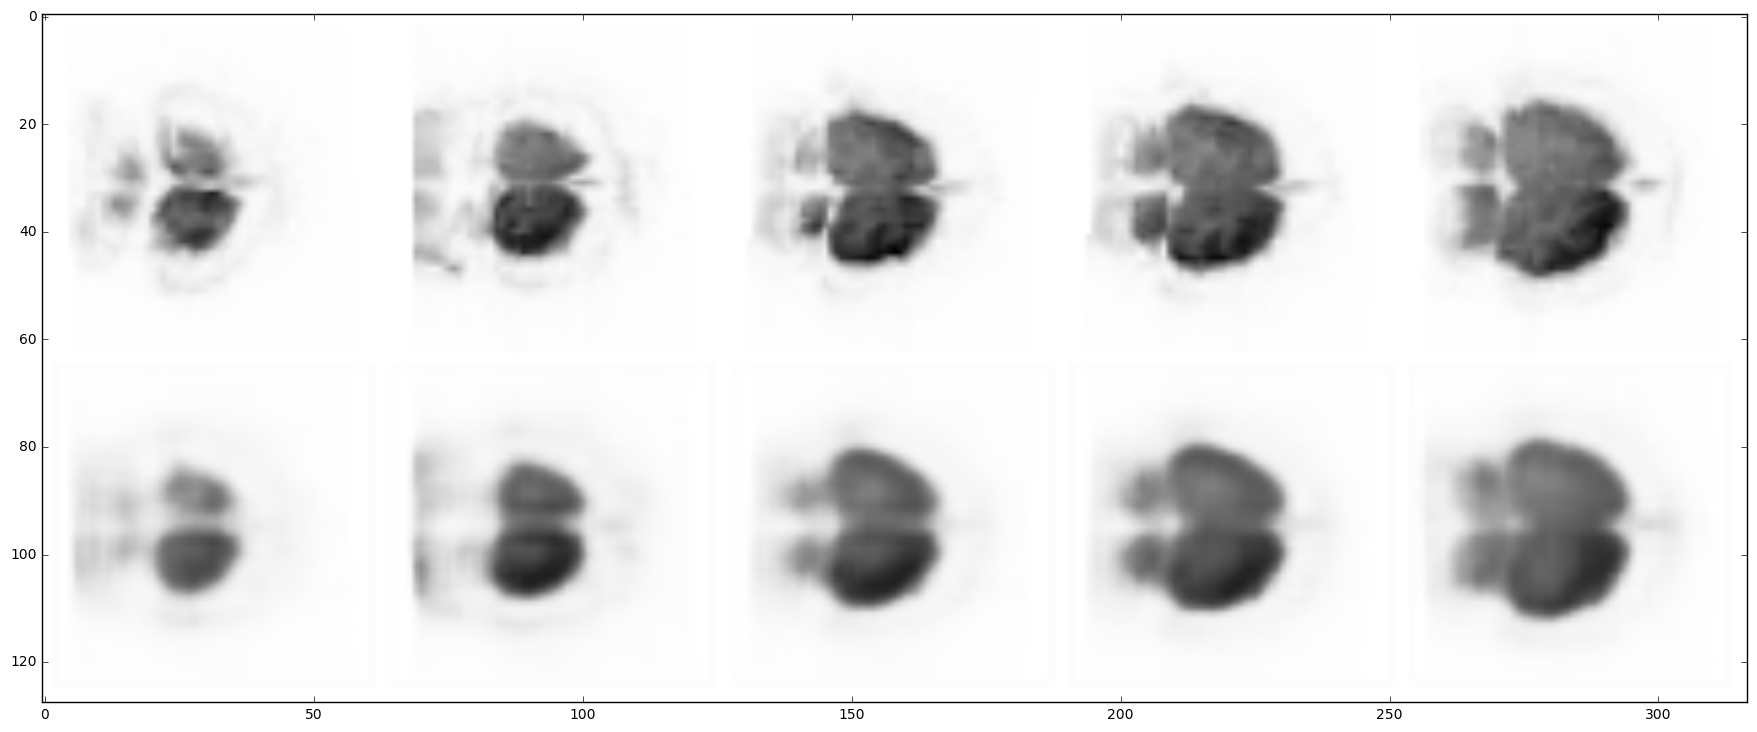

In [23]:
plt.rcParams['grid.linewidth'] = 0.0
fig = plt.figure(figsize=(22,22))
plt.imshow(grid[0], cmap="Greys")

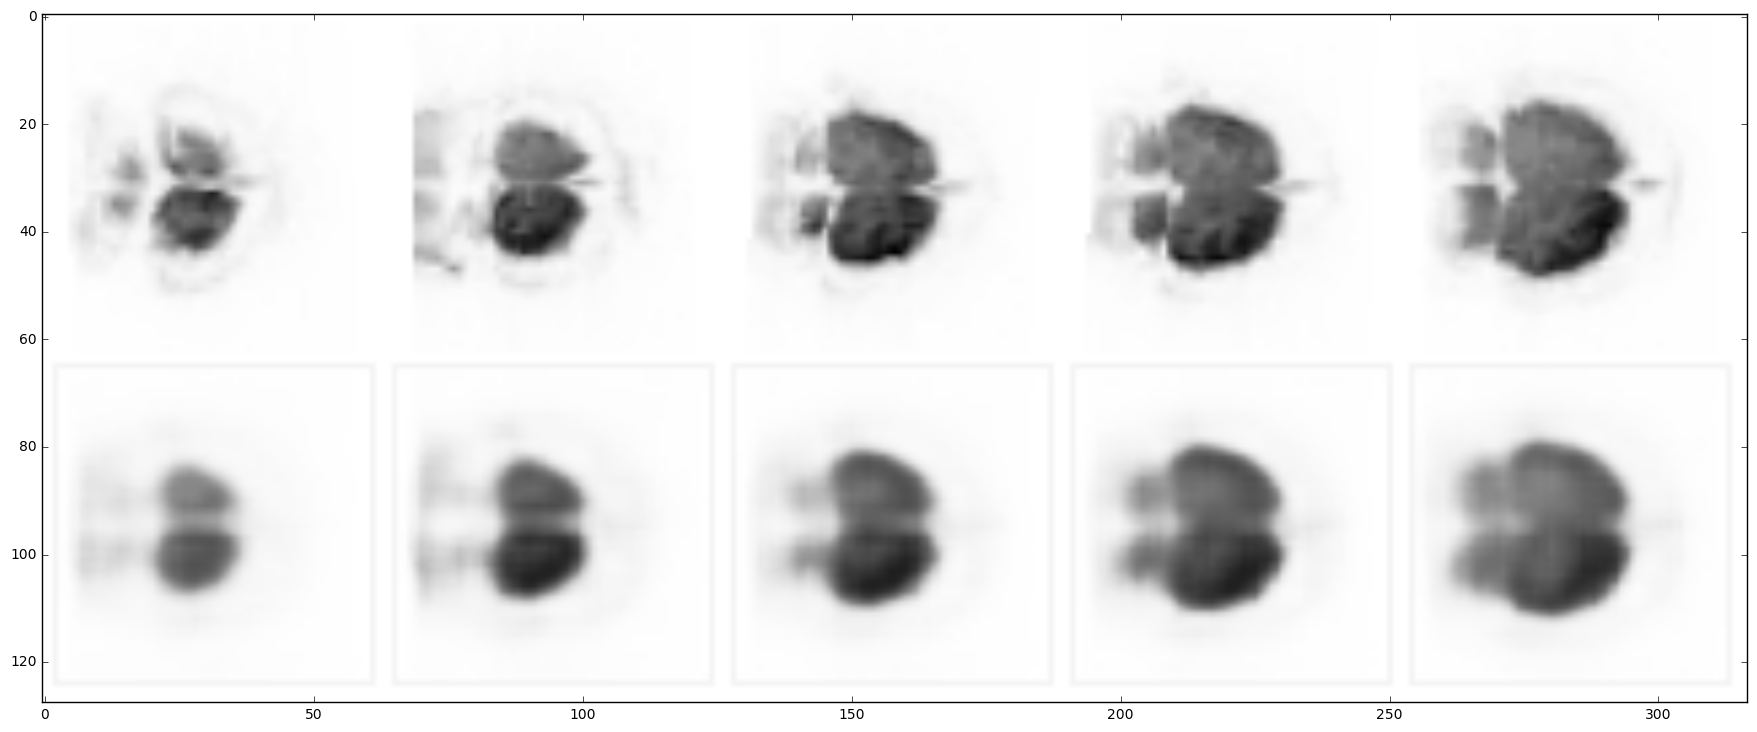

In [23]:
plt.rcParams['grid.linewidth'] = 0.0
fig = plt.figure(figsize=(22,22))
plt.imshow(grid[0], cmap="Greys")

The original images are in the first row and their reconstruction are below.